In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iisignature
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score

#btc = yf.download('BTC-USD', start='2014-09-17', end='2024-12-31', interval='1d', timeout=60, progress=False, threads=False)

btc = pd.read_csv('BTC-USD.csv', index_col=0, parse_dates=True)
btc = btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].dropna() # 确保所有列都在
#btc = btc[['Close', 'Volume']].dropna()

#price = btc['Adj Close'].values
#volume = btc['Volume'].values

price = btc['Close'].values
volume = np.log(btc['Volume']).values

#btc = btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].dropna() # 确保所有列都在

## 示例：计算对数价格和对数成交量
#btc['Log_Close'] = np.log(btc['Close'])
#btc['Log_Volume'] = np.log(btc['Volume'])

# 示例：计算每日价格范围
#btc['Daily_Range'] = btc['High'] - btc['Low']

timestamps = np.linspace(0, 1, len(price)) 



MMD² between rising and other segments (gamma=0.0006): 0.027222


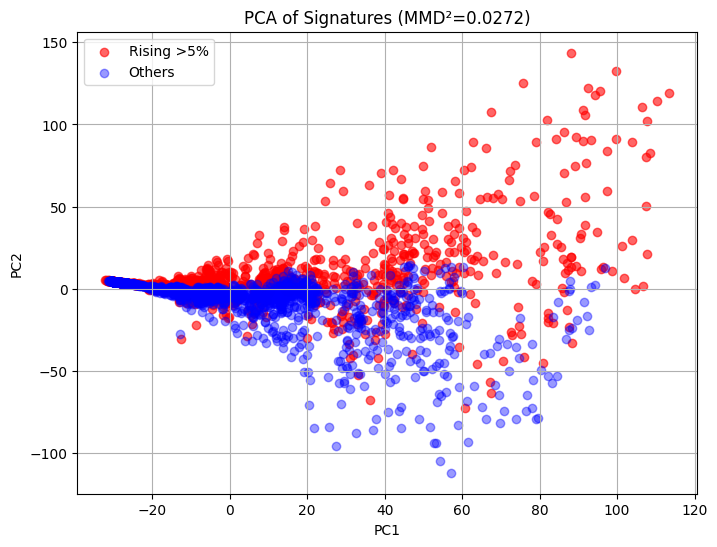

In [6]:
# Transformations
def lead_lag_transform(x):
    x_repeated = np.repeat(x, 2, axis=0)
    lead = x_repeated[1:]
    lag = x_repeated[:-1]
    return np.concatenate([lead, lag], axis=1)

def cumulative_sum(path):
    return np.cumsum(path, axis=0)

def time_integrated(path, ts):
    ts_scaled = np.interp(ts, (ts.min(), ts.max()), (0, 1))
    ts_expanded = np.interp(np.linspace(0, len(ts_scaled)-1, len(path)), np.arange(len(ts_scaled)), ts_scaled)
    return np.column_stack([path, ts_expanded])

def invisibility_reset(path):
    last = path[-1]
    reset_path = np.vstack([path, last, np.zeros_like(last)])
    flag = np.vstack([np.zeros((len(path), 1)), np.ones((2, 1))])
    return np.hstack([reset_path, flag])

def build_signature_path(price, volume, ts):
    path = np.column_stack([price, volume])
    path = lead_lag_transform(path)
    path = cumulative_sum(path)
    path = time_integrated(path, ts)
    path = invisibility_reset(path)
    return path


# Window = 7 and Calculate the signature
def extract_signatures(price, volume, window=7, sig_order=3):
    signatures = []
    labels = []
    for i in range(len(price) - window + 1):
        p_slice = price[i:i+window]
        v_slice = volume[i:i+window]

        # label: up 5%
        price_arr = np.array(p_slice)
        min_prices = np.minimum.accumulate(price_arr[::-1])[::-1]  # 滑动最小值
        pct_changes = (price_arr - min_prices) / min_prices
        max_pct_change = np.max(pct_changes)
        is_rising = max_pct_change >= 0.05
        labels.append(is_rising)

        # Signature Path 
        ts = np.arange(window)
        path = build_signature_path(p_slice, v_slice, ts)
        sig = iisignature.sig(path, sig_order)
        signatures.append(sig)

    return np.array(signatures), np.array(labels)

#calculate MMD and PCA
def analyze_signature_diff_mmd(signatures, labels, gamma=None, visualize=True):
    scaler = StandardScaler()
    sigs_scaled = scaler.fit_transform(signatures)

    sig_pos = sigs_scaled[labels]
    sig_neg = sigs_scaled[~labels]

    # define gamma
    if gamma is None:
        gamma = 1.0 / sigs_scaled.shape[1]

    # RBF MMD
    K_xx = rbf_kernel(sig_pos, sig_pos, gamma=gamma)
    K_yy = rbf_kernel(sig_neg, sig_neg, gamma=gamma)
    K_xy = rbf_kernel(sig_pos, sig_neg, gamma=gamma)

    m, n = len(sig_pos), len(sig_neg)
    mmd2 = K_xx.sum() / (m*m) + K_yy.sum() / (n*n) - 2 * K_xy.sum() / (m*n)

    print(f"MMD² between rising and other segments (gamma={gamma:.4f}): {mmd2:.6f}")

    # CPA visualisation
    if visualize:
        X_pca = PCA(n_components=2).fit_transform(sigs_scaled)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='red', label='Rising >5%', alpha=0.6)
        plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='blue', label='Others', alpha=0.4)
        plt.title(f"PCA of Signatures (MMD²={mmd2:.4f})")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":

    signatures, labels = extract_signatures(price, volume, window=7, sig_order=4)

    analyze_signature_diff_mmd(signatures, labels, gamma=None)

